**Pedro Rivero**  
Quantum Developer *@ IBM Quantum*  
pedro.rivero@ibm.com 

# Local Reality and the CHSH Inequality
_An exercise on translating [this section](https://qiskit.org/textbook/ch-demos/chsh.html) of the qiskit textbook to error mitigated primitives._

In [1]:
## QISKIT
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator, BackendEstimator
from qiskit.providers.fake_provider import FakeNairobi as Backend

## ZNE
from zne import zne, ZNEStrategy
from zne.noise_amplification import LocalFoldingAmplifier
from zne.extrapolation import PolynomialExtrapolator

## OTHER
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rcParams["figure.dpi"] = 300
plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern Roman"})
plt.rcParams.update({'font.size': 16})

## Problem definition

In the original statement, it is said that the two orthogonal basis in which we measure should be at differet relative angles from one another; which amounts to a _pasive rotation_ (i.e. rotating the frame of reference). 

It is actaully easier to define the problem programatically if we perform an _active rotation_ and keep the measurement basis the same. This is so because performing a rotation on a qubit amounts to trivially adding a parametrized `Ry` gate, meanwhile a rotation of the basis would amount parametrizing the observable, which turns out to be more involved with current software capabilities.

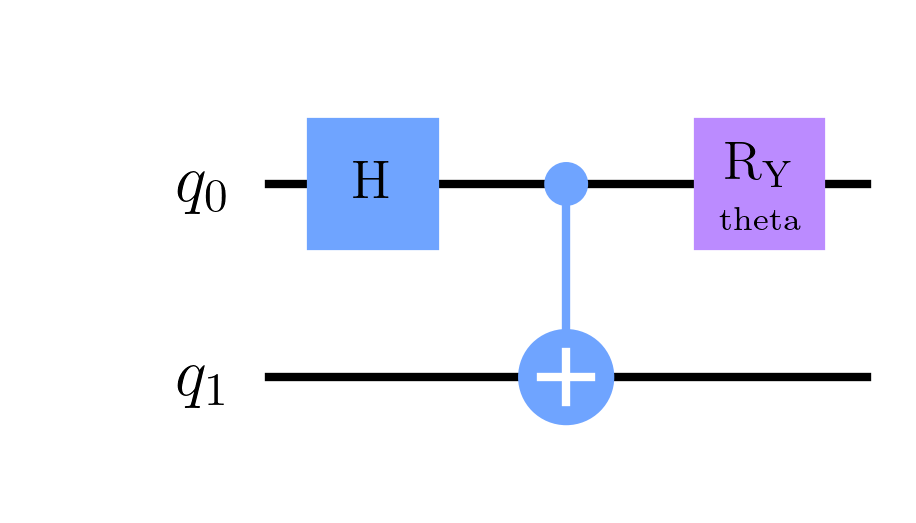

In [3]:
## CIRCUIT
cir = QuantumCircuit(2)
cir.h(0)
cir.cx(0, 1)
cir.ry(Parameter("theta"), 0)
display(cir.draw("mpl"))

## THETA
theta_vec = np.linspace(-np.pi, np.pi, 15)

## OBSERVABLE
obs1 = SparsePauliOp(["ZZ", "ZX", "XZ", "XX"], [1, -1, +1, 1])
obs2 = SparsePauliOp(["ZZ", "ZX", "XZ", "XX"], [1, +1, -1, 1])

## Solutions
We will solve this problem in three different ways:
1. _Ideal_ → On an ideal simulator
2. _Noisy_ → On a noisy simulator (e.g. `FakeNairobi`)
3. _Error mitigated_ → Using ZNE on the previous noisy simulator

The third of these approaches is new, and cannot be found on the original section of the qiskit textbook.

### Ideal

In [4]:
## IDEAL ESTIMATOR
estimator = Estimator()

## JOBS
job1 = estimator.run(
    circuits = [cir] * len(theta_vec), 
    observables = [obs1] * len(theta_vec), 
    parameter_values = [[v] for v in theta_vec],
)
job2 = estimator.run(
    circuits = [cir] * len(theta_vec), 
    observables = [obs2] * len(theta_vec), 
    parameter_values = [[v] for v in theta_vec],
)


## RESULTS
CHSH1_ideal = job1.result()
CHSH2_ideal = job2.result()

### Noisy

In [5]:
## NOISY ESTIMATOR
backend = Backend()
estimator = BackendEstimator(backend=backend)

## JOBS
job1 = estimator.run(
    circuits = [cir] * len(theta_vec), 
    observables = [obs1] * len(theta_vec), 
    parameter_values = [[v] for v in theta_vec],
)
job2 = estimator.run(
    circuits = [cir] * len(theta_vec), 
    observables = [obs2] * len(theta_vec), 
    parameter_values = [[v] for v in theta_vec],
)


## RESULTS
CHSH1_noisy = job1.result()
CHSH2_noisy = job2.result()

### Error mitigated

In [6]:
## MITIGATED ESTIMATOR
ZNEEstimator = zne(BackendEstimator)
zne_strategy = ZNEStrategy(
    noise_factors=(1,7,13),
    noise_amplifier=LocalFoldingAmplifier()
)
estimator = ZNEEstimator(backend=backend, zne_strategy=zne_strategy)

## JOBS
job1 = estimator.run(
    circuits = [cir] * len(theta_vec), 
    observables = [obs1] * len(theta_vec), 
    parameter_values = [[v] for v in theta_vec],
)
job2 = estimator.run(
    circuits = [cir] * len(theta_vec), 
    observables = [obs2] * len(theta_vec), 
    parameter_values = [[v] for v in theta_vec],
)


## RESULTS
CHSH1_mitigated = job1.result()
CHSH2_mitigated = job2.result()

## Results

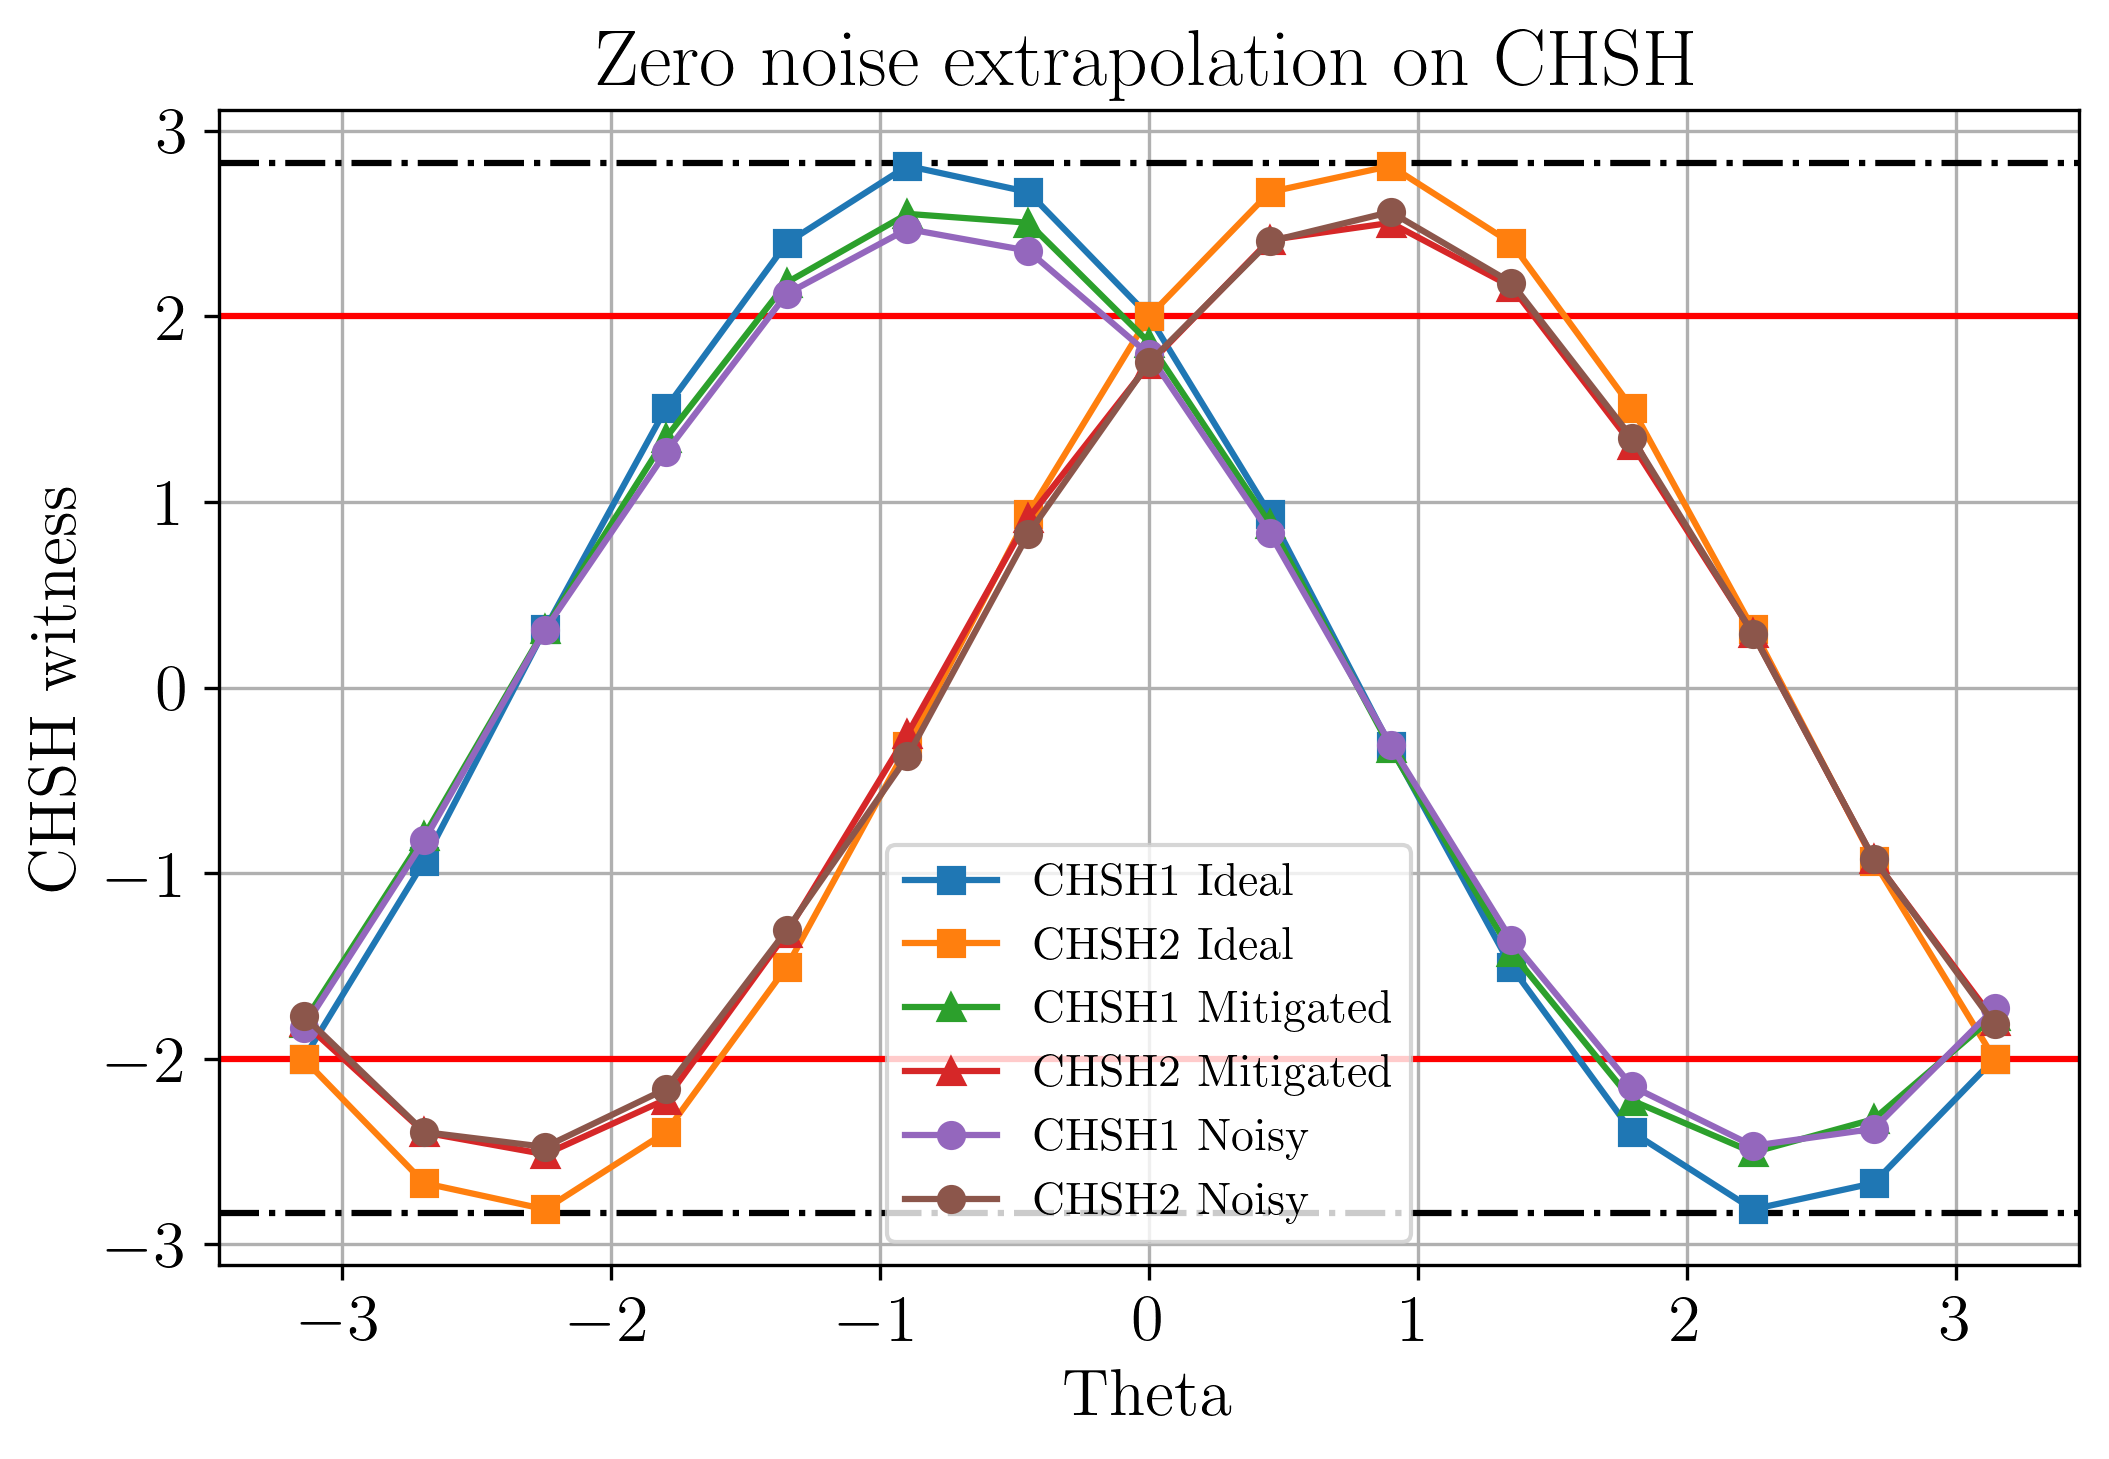

In [7]:
## CONFIG
# plt.rcParams.update({'font.size': 22, 'lines.markersize': 10, 'lines.linewidth': 1.8})
plt.figure(figsize=(8,5))

## LIMITS
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')

## PLOTS
plt.plot(theta_vec,CHSH1_ideal,'s-',label = 'CHSH1 Ideal')
plt.plot(theta_vec,CHSH2_ideal,'s-',label = 'CHSH2 Ideal')
plt.plot(theta_vec,CHSH1_mitigated,'^-',label = 'CHSH1 Mitigated')
plt.plot(theta_vec,CHSH2_mitigated,'^-',label = 'CHSH2 Mitigated')
plt.plot(theta_vec,CHSH1_noisy,'o-',label = 'CHSH1 Noisy')
plt.plot(theta_vec,CHSH2_noisy,'o-',label = 'CHSH2 Noisy')

## EMBELLISH 
plt.title("Zero noise extrapolation on CHSH")
plt.xlabel('Theta')
plt.ylabel('CHSH witness')
plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 11})
plt.legend()

plt.show()

In [8]:
print(" # |  MITIGATED   <-    (NOISY DATA POINTS) \n" + "-" * 70)
for i in range(len(CHSH1_mitigated.values)):
    print(
        f"{i:2} |  "
        f"{CHSH1_mitigated.values[i]:+.5f}"
        f"    <-    "
        f"{CHSH1_mitigated.metadata[i]['zne']['noise_amplification']['values']}"
    )

 # |  MITIGATED   <-    (NOISY DATA POINTS) 
----------------------------------------------------------------------
 0 |  -1.80550    <-    (-1.80859375, -1.677734375, -1.646484375)
 1 |  -0.79688    <-    (-0.826171875, -0.7734375, -0.873046875)
 2 |  +0.31820    <-    (0.310546875, 0.2734375, 0.23046875)
 3 |  +1.34587    <-    (1.314453125, 1.287109375, 1.15234375)
 4 |  +2.18197    <-    (2.193359375, 1.962890625, 1.931640625)
 5 |  +2.55225    <-    (2.5, 2.494140625, 2.283203125)
 6 |  +2.50456    <-    (2.4765625, 2.255859375, 2.0703125)
 7 |  +1.85905    <-    (1.794921875, 1.791015625, 1.533203125)
 8 |  +0.88281    <-    (0.916015625, 0.705078125, 0.767578125)
 9 |  -0.32633    <-    (-0.294921875, -0.326171875, -0.2109375)
10 |  -1.42627    <-    (-1.384765625, -1.326171875, -1.140625)
11 |  -2.22493    <-    (-2.20703125, -2.0, -1.859375)
12 |  -2.50407    <-    (-2.48828125, -2.33203125, -2.216796875)
13 |  -2.32520    <-    (-2.30859375, -2.16796875, -2.0546875)
14 |  -1.

## Conclussions
Although we clearly observe how our results exceed the predicted classical boundary —showing authentic quantum behavior— ZNE does not seem to improve the resutls significantly for this particular problem. Nonetheless, different behavior is observed depending on the backend that is used.

In [9]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright